# Stock Trading (Modular)

Notebook orchestration; reusable code lives in `projects/stock_trading/stock_trading`.

In [ ]:
# Optional: install dependencies once
# !pip install stable-baselines3 gym-anytrading pandas matplotlib yfinance -q

In [1]:
# Make local package importable
import sys
from pathlib import Path

here = Path.cwd().resolve()
if (here / 'stock_trading').exists():
    sys.path.insert(0, str(here))
elif (here.parent / 'stock_trading').exists():
    sys.path.insert(0, str(here.parent))

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stock_trading.data import download_stock_data, split_train_test
from stock_trading.indicators import add_technical_indicators, plot_technical_indicators
from stock_trading.train import train_baseline_a2c, train_indicator_a2c
from stock_trading.eval import backtest_baseline, backtest_indicators
from stock_trading.plotting import plot_price_history, plot_strategy, compare_agents

## Load Historical Stock Data

In [3]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-12-31'

print(f'Downloading {ticker} data from {start_date} to {end_date}...')
df = download_stock_data(ticker, start_date, end_date)
print(f'Data loaded: {len(df)} days')
print(f'Date range: {df.index[0]} to {df.index[-1]}')
print(df.head())

C:\Users\Matias\source\repos\adml-rl\projects\stock_trading\stock_trading\data.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Data loaded: 1006 days
Date range: 2020-01-02 00:00:00 to 2023-12-29 00:00:00
Price            Open       High        Low      Close     Volume
Date                                                             
2020-01-02  71.476615  72.528597  71.223274  72.468277  135480400
2020-01-03  71.696175  72.523762  71.539345  71.763733  146322800
2020-01-06  70.885479  72.374169  70.634547  72.335564  118387200
2020-01-07  72.345204  72.600960  71.775789  71.995354  108872000
2020-01-08  71.698589  73.455103  71.698589  73.153503  132079200


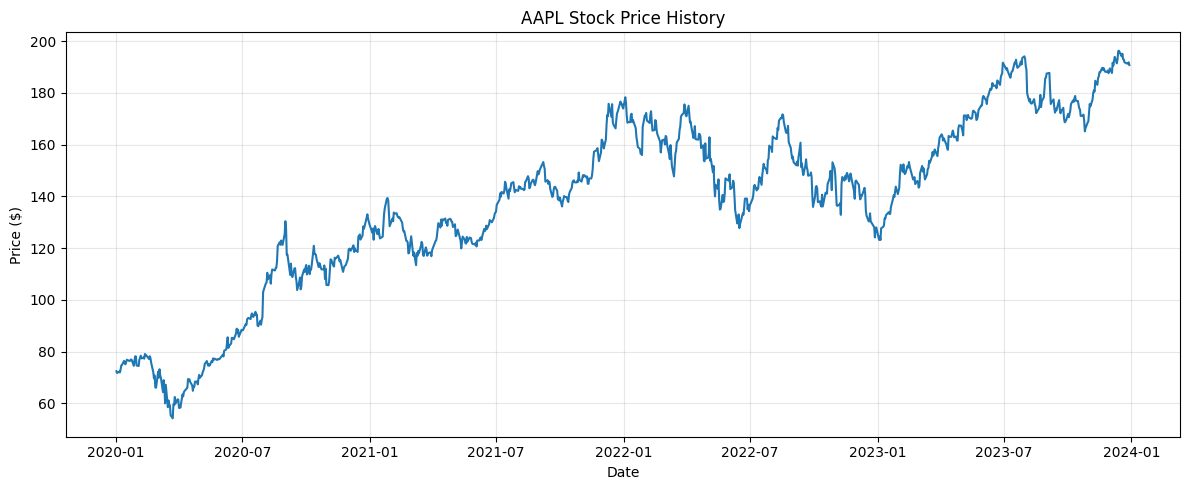

Price range: $54.26 - $196.26
Buy-and-hold return: 163.2%


In [4]:
plot_price_history(df, ticker)
min_price = df['Close'].min().item()
max_price = df['Close'].max().item()
bah = (df['Close'].iloc[-1].item() / df['Close'].iloc[0].item() - 1) * 100
print(f'Price range: ${min_price:.2f} - ${max_price:.2f}')
print(f'Buy-and-hold return: {bah:.1f}%')

## Split Data: Train/Test

In [5]:
train_df, test_df = split_train_test(df, train_ratio=0.8)
print(f'Training data: {len(train_df)} days ({train_df.index[0]} to {train_df.index[-1]})')
print(f'Test data: {len(test_df)} days ({test_df.index[0]} to {test_df.index[-1]})')

Training data: 804 days (2020-01-02 00:00:00 to 2023-03-13 00:00:00)
Test data: 202 days (2023-03-14 00:00:00 to 2023-12-29 00:00:00)


## Train Baseline Agent

In [ ]:
baseline_cfg = {
    'window_size': 5,
    'total_timesteps': 50_000,
    'learning_rate': 7e-4,
    'gamma': 0.99,
    'seed': 42,
}
model, _env = train_baseline_a2c(train_df, **baseline_cfg)
print('Training complete!')

Training complete!


## Backtest (Baseline)

In [8]:
base_results = backtest_baseline(model, test_df)
print('Backtest Results:')
print(f"  Total reward: {base_results['total_reward']:.2f}")
print(f"  Total profit: ${base_results['total_profit']:.2f}")
print(f"  Total return: {base_results['total_return']:.2f}%")

Backtest Results:
  Total reward: 0.00
  Total profit: $1.21
  Total return: 20.65%


## Plots (Baseline)

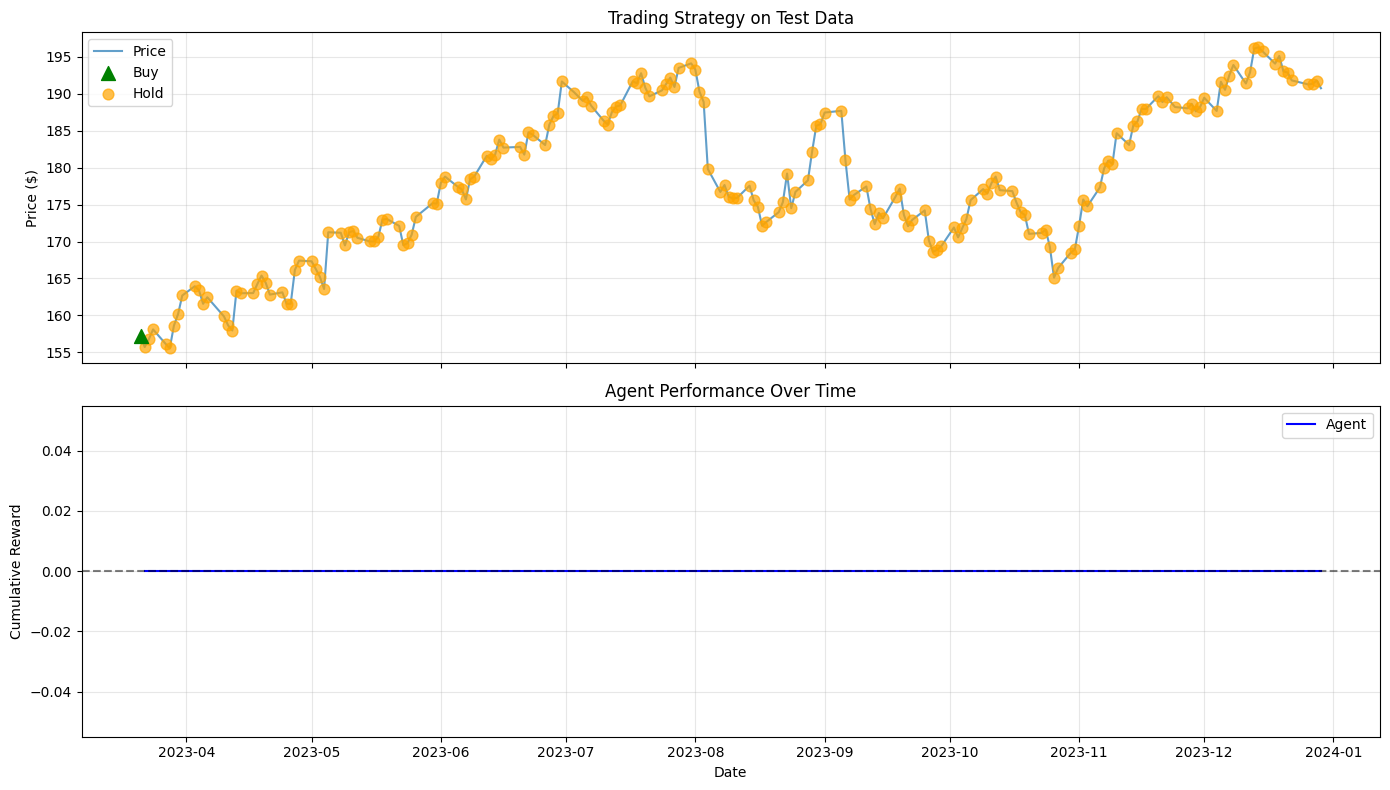

Comparison:
  Agent return: 20.65%
  Buy-and-hold return: 26.69%


In [9]:
bah_return, agent_return = plot_strategy(
    test_df, base_results['actions'], base_results['rewards'], base_results['total_return']
 )
print('Comparison:')
print(f'  Agent return: {agent_return:.2f}%')
print(f'  Buy-and-hold return: {bah_return:.2f}%')

## Save Baseline Model

In [17]:
os.makedirs('../models', exist_ok=True)
date_str = datetime.now().strftime('%Y-%m-%d')
model_name = (
    f"{date_str}_a2c_baseline_"
    f"ws-{baseline_cfg['window_size']}_"
    f"lr-{baseline_cfg['learning_rate']}_"
    f"gamma-{baseline_cfg['gamma']}_"
    f"seed-{baseline_cfg['seed']}_"
    f"t-steps-{baseline_cfg['total_timesteps']}"
 )
model.save(f"../models/{model_name}")
print(f"Saved baseline model to models/{model_name}")

Saved baseline model to models/2026-01-15_a2c_baseline_ws-5_lr-0.0007_gamma-0.99_seed-42_t-steps-50000


## Indicators Agent (Optional)

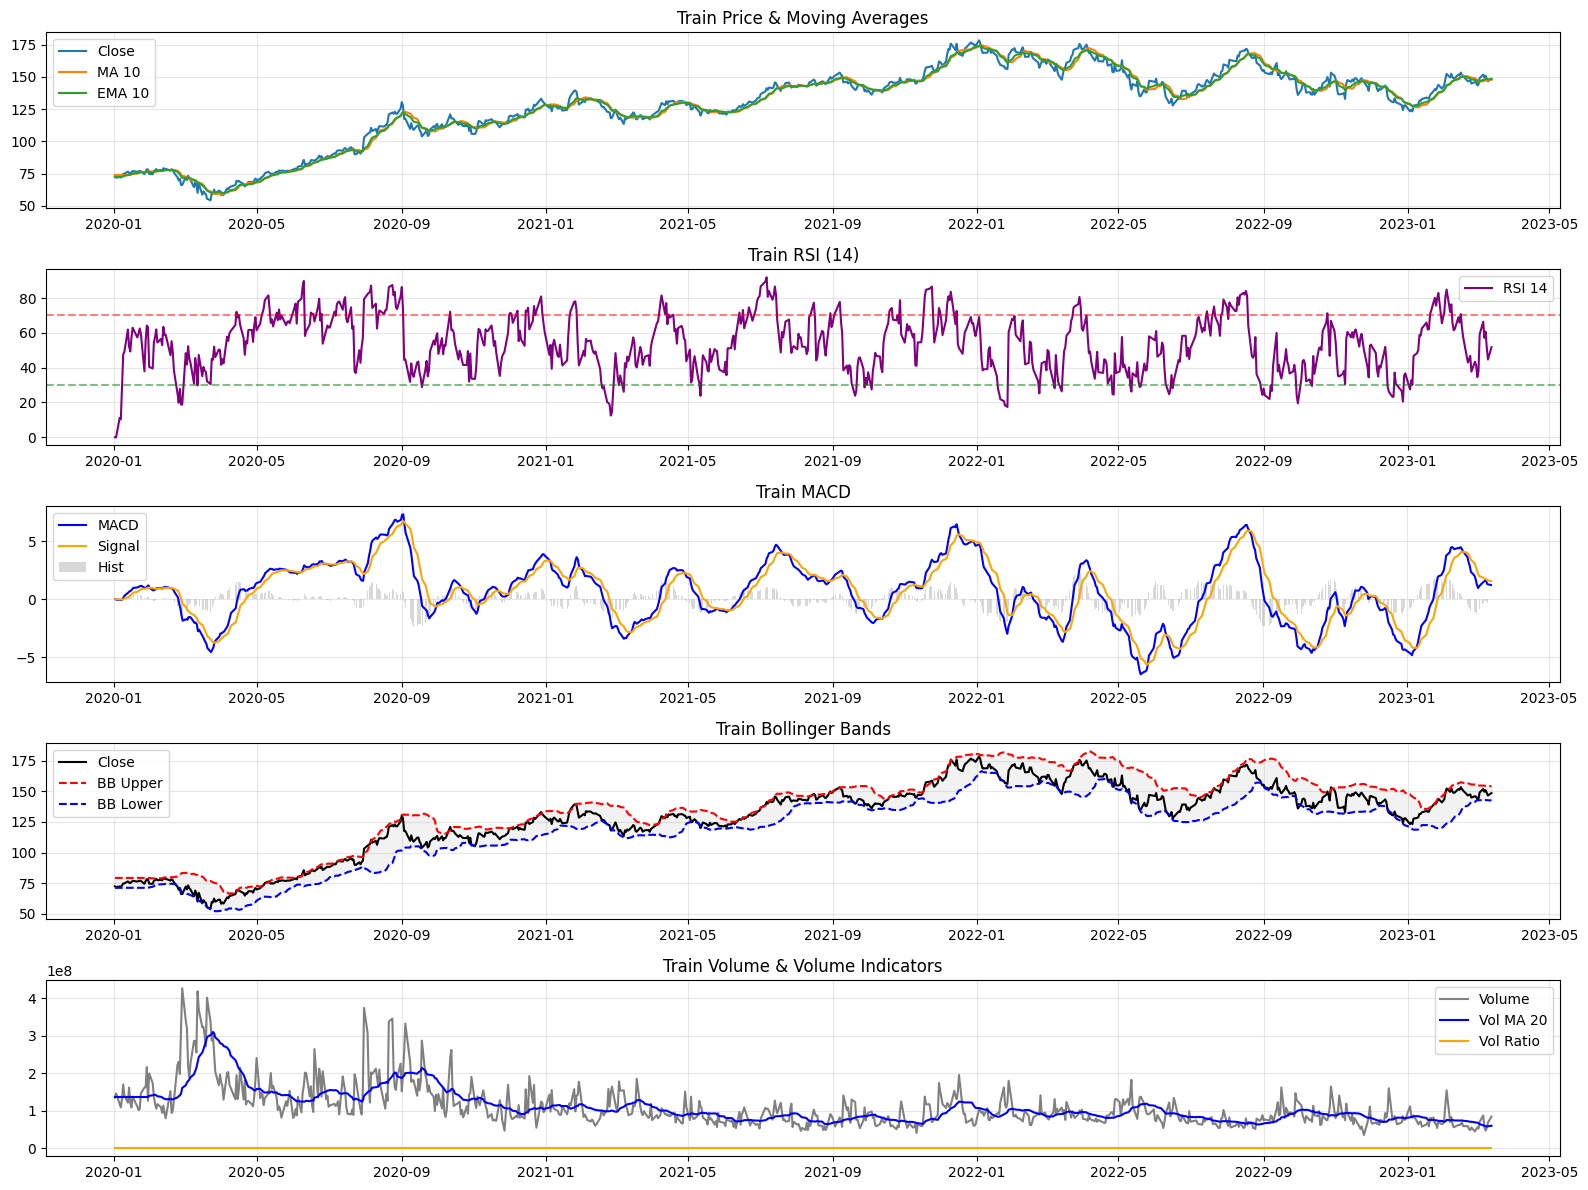

Indicator columns: ['ma_10', 'ema_10', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'bb_upper', 'bb_lower', 'bb_width', 'vol_ma_20', 'vol_ratio']


In [10]:
train_ind_df = add_technical_indicators(train_df)
test_ind_df = add_technical_indicators(test_df)
plot_technical_indicators(train_ind_df, title_prefix='Train ')
print('Indicator columns:', [c for c in train_ind_df.columns if c not in train_df.columns])

In [ ]:
indicator_cfg = {
    'window_size': 5,
    'total_timesteps': 500_000,
    'learning_rate': 7e-4,
    'gamma': 0.9,
    'seed': 24,
    'reward_type': 'risk_adjusted',
    'risk_factor': 0.01,
}
model_ind, ind_env = train_indicator_a2c(train_ind_df, **indicator_cfg)
print('Training complete for indicators agent!')

Training complete for indicators agent!


In [18]:
ind_results = backtest_indicators(model_ind, test_ind_df)
print('Indicator agent backtest results:')
print(f"  Total reward: {ind_results['total_reward']:.2f}")
print(f"  Total profit (cumulative): {ind_results['total_profit']:.2f}")

Indicator agent backtest results:
  Total reward: 37.20
  Total profit (cumulative): 37.20


## Compare Agents (Baseline vs Indicators)

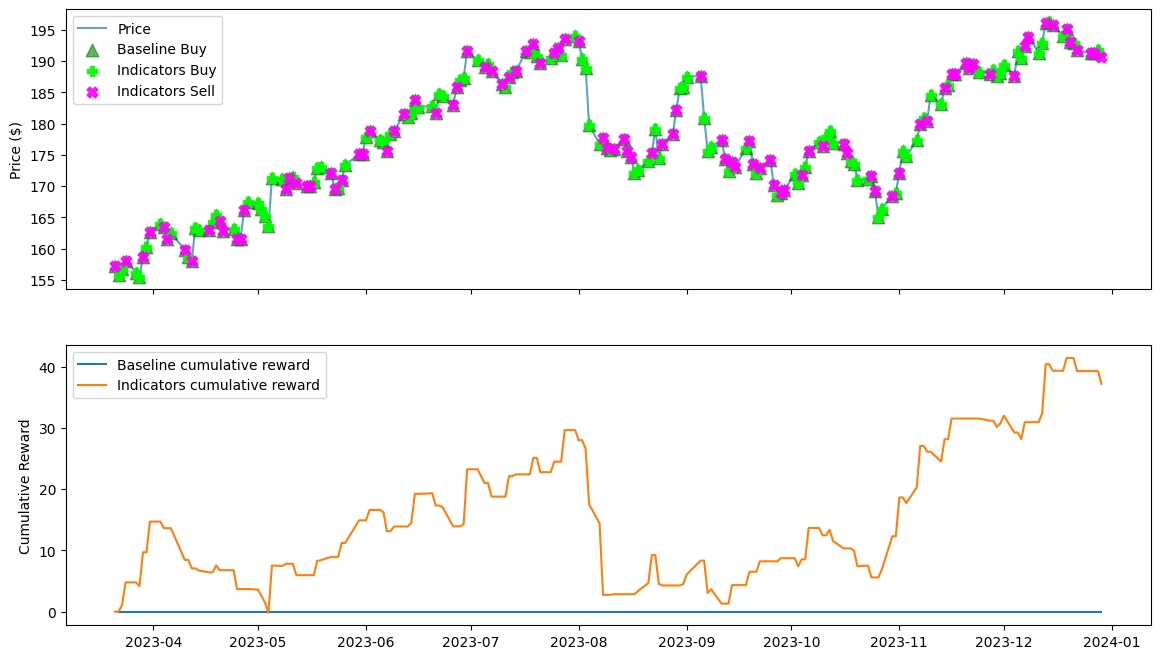

In [19]:
compare_agents(
    test_df,
    base_results['actions'], base_results['rewards'],
    ind_results['actions'], ind_results['rewards'],
)

## Save Indicators Model

In [22]:
model_name = (
    f"{date_str}_a2c_indicators_"
    f"ws-{indicator_cfg['window_size']}_"
    f"lr-{indicator_cfg['learning_rate']}_"
    f"gamma-{indicator_cfg['gamma']}_"
    f"seed-{indicator_cfg['seed']}_"
    f"r-type-{indicator_cfg['reward_type']}_"
    f"r-factor-{indicator_cfg['risk_factor']}_"
    f"t-steps-{indicator_cfg['total_timesteps']}"
 )
model_ind.save(f"../models/{model_name}")
print(f"Saved indicators model to models/{model_name}")

Saved indicators model to models/2026-01-15_a2c_indicators_ws-5_lr-0.0007_gamma-0.9_seed-24_r-type-risk_adjusted_r-factor-0.01_t-steps-500000


## Batch Experiments (Indicators)

In [ ]:
indicator_runs = [
    {
        'window_size': 5,
        'total_timesteps': 200_000,
        'learning_rate': 7e-4,
        'gamma': 0.95,
        'seed': 24,
        'reward_type': 'simple',
        'risk_factor': 0.0,
    },
    {
        'window_size': 5,
        'total_timesteps': 300_000,
        'learning_rate': 7e-4,
        'gamma': 0.95,
        'seed': 24,
        'reward_type': 'risk_adjusted',
        'risk_factor': 0.005,
    },
    {
        'window_size': 5,
        'total_timesteps': 500_000,
        'learning_rate': 7e-4,
        'gamma': 0.9,
        'seed': 24,
        'reward_type': 'risk_adjusted',
        'risk_factor': 0.01,
    },
    {
        'window_size': 5,
        'total_timesteps': 500_000,
        'learning_rate': 7e-4,
        'gamma': 0.9,
        'seed': 24,
        'reward_type': 'sharpe',
        'risk_factor': 0.0,
    },
 ]

os.makedirs('../models', exist_ok=True)

batch_results = []
for idx, cfg in enumerate(indicator_runs, start=1):
    print(f"\n[Run {idx}/{len(indicator_runs)}] {cfg}")
    model_i, env_i = train_indicator_a2c(train_ind_df, **cfg)
    res_i = backtest_indicators(model_i, test_ind_df)

    model_name = (
        f"{date_str}_a2c_indicators_"
        f"ws-{cfg['window_size']}_"
        f"lr-{cfg['learning_rate']}_"
        f"gamma-{cfg['gamma']}_"
        f"seed-{cfg['seed']}_"
        f"r-type-{cfg['reward_type']}_"
        f"r-factor-{cfg['risk_factor']}_"
        f"t-steps-{cfg['total_timesteps']}"
    )
    model_i.save(f"../models/{model_name}")
    print(f"Saved: {model_name}")

    batch_results.append({
        'name': model_name,
        'cfg': cfg,
        'rewards': res_i['rewards'],
        'total_reward': res_i['total_reward'],
        'total_profit': res_i['total_profit'],
    })

print("\nSummary:")
for r in batch_results:
    print(f"- {r['name']}: reward={r['total_reward']:.2f}, profit={r['total_profit']:.2f}")

plt.figure(figsize=(12, 6))
for r in batch_results:
    plt.plot(np.cumsum(r['rewards']), label=r['name'])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Indicators: Cumulative Reward Comparison')
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()